Experiment with a 9000K continumn model from https://arxiv.org/pdf/2201.08805.pdf - can we normalize it to the NUV spectrum?

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models
from matplotlib.gridspec import GridSpec
from astropy.stats import sigma_clip

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [3]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/' 

In [4]:
stars = os.listdir(path)
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']

3151.8121121219247


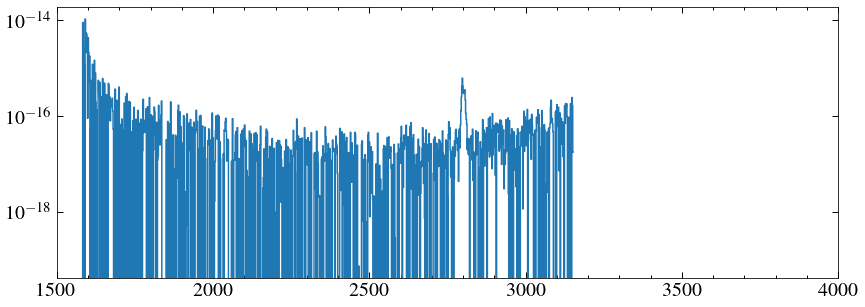

3067.4203525110297


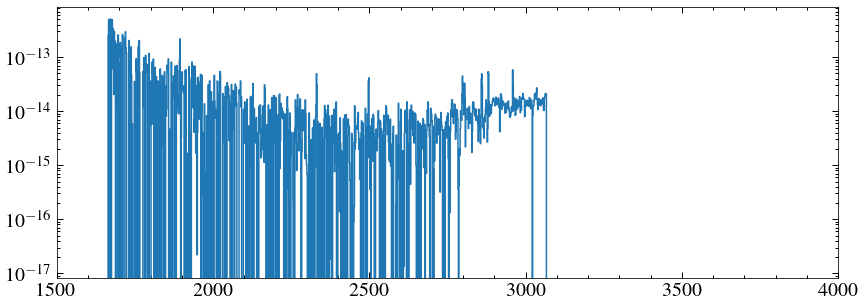

3149.2501037447664


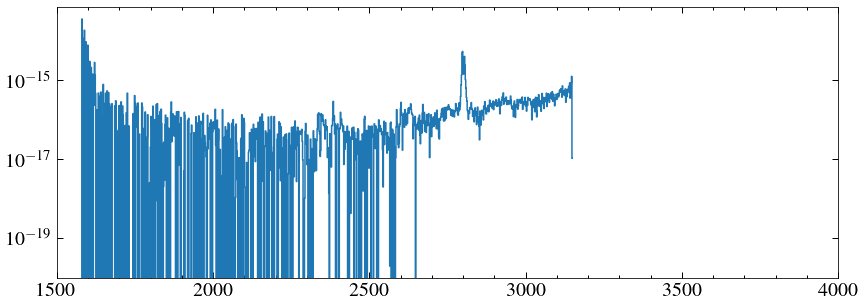

3157.003302496834


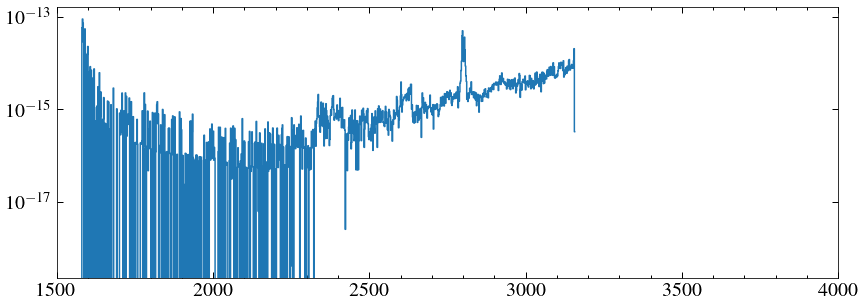

3153.498384661432


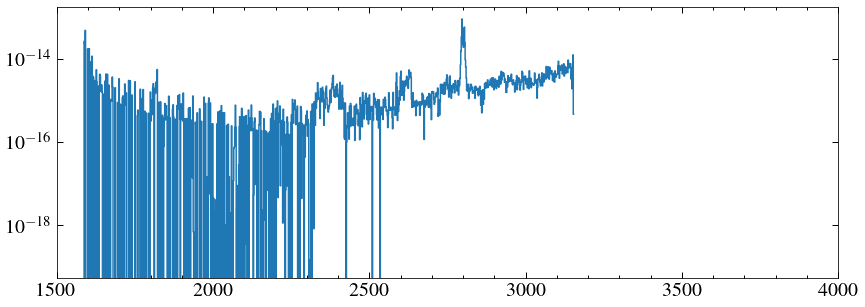

3149.305686967301


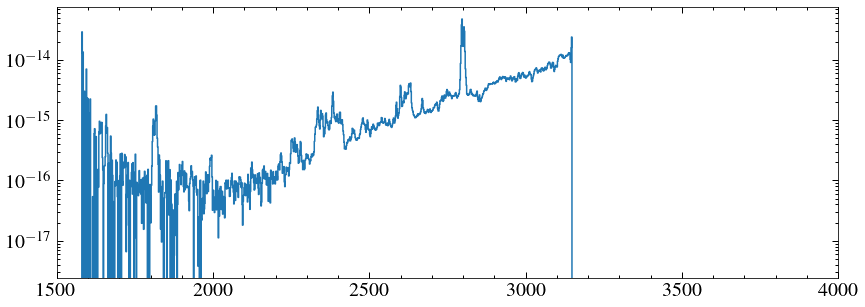

3155.79873394521


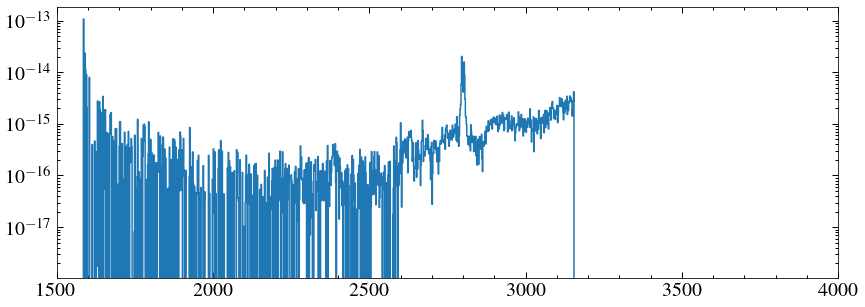

3067.521024275104


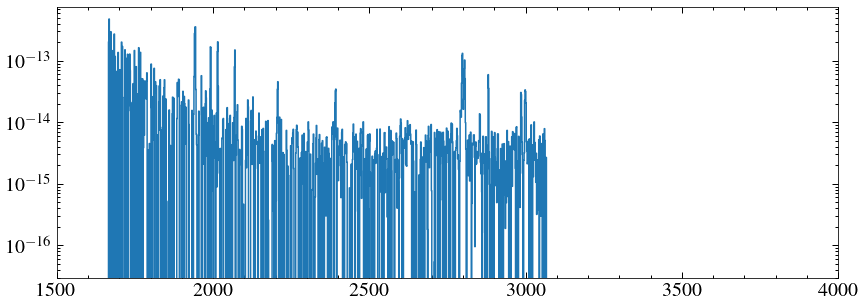

3150.159405805074


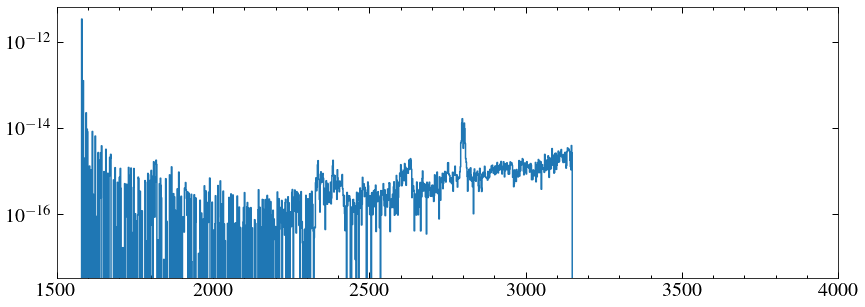

3155.002379901846


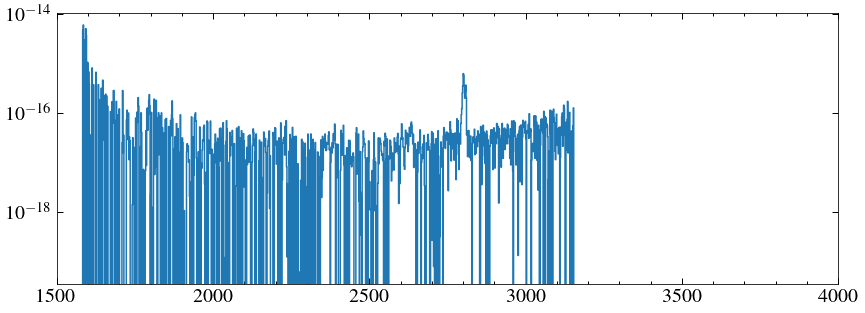

3150.125506623227


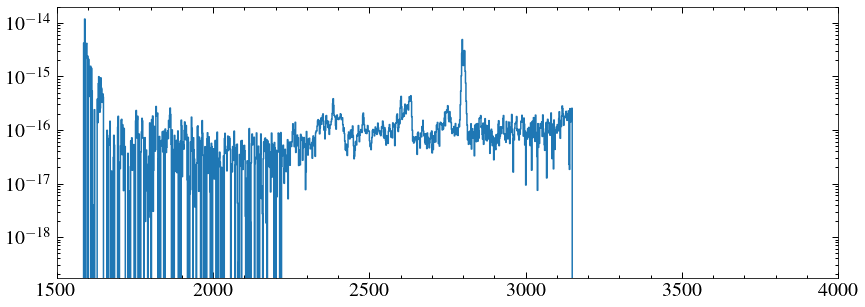

In [5]:
for star in stars:
    # print(star)
    if star != 'TRAPPIST-1':
        ppath = '{}{}/hlsp_muscles_model_phx_{}_na_v10_component-spec.fits'.format(path, star, star.lower())
        phx = fits.getdata(ppath, 1)
        normfac = fits.getheader(ppath, 0)['NORMFAC']
        npath = glob.glob('{}{}/hlsp_muscles_hst_stis_{}_g230l*_v10_component-spec.fits'.format(path, star, star.lower()))[0]
        nuv = fits.getdata(npath, 1)
        # plt.plot(phx['WAVELENGTH'], phx['FLUX']*normfac)        
        plt.step(nuv['WAVELENGTH'], nuv['FLUX'], where='mid')
        plt.xlim(1500, 4000)
        # plt.xlim(2750, 2850)
        # plt.xlim(2000, 2500)
        plt.yscale('log')
        print(nuv['WAVELENGTH'][-1])
        # plt.ylim(1e-19, )
        plt.show()

In [6]:
nuvspecs = glob.glob('{}*/*g230l*.fits'.format(path))
nuvspecs

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_hst_stis_gj1132_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ15A/hlsp_muscles_hst_stis_gj15a_g230lb_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_hst_stis_gj163_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_hst_stis_gj649_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_hst_stis_gj699_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ729/hlsp_muscles_hst_stis_gj729_g230lb_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/

In [7]:
phxspecs = glob.glob('{}*/*phx*.fits'.format(path))
phxspecs 

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_model_phx_gj1132_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ15A/hlsp_muscles_model_phx_gj15a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_model_phx_gj163_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_model_phx_gj649_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_model_phx_gj674_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_phx_gj676a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_model_phx_gj699_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ729/hlsp_muscles_model_phx_gj729_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscle

In [8]:
seds = glob.glob('{}*/hlsp_muscles_multi_multi_*_broadband_v10_const-res-sed.fits'.format(path))
seds

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_multi_multi_gj1132_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ15A/hlsp_muscles_multi_multi_gj15a_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_multi_multi_gj163_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_multi_multi_gj649_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_multi_multi_gj674_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_multi_multi_gj676a_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_multi_multi_gj699_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ729/hlsp_muscles_multi_multi_gj729_broadband_v10_c

GJ1132
116
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0     4.305125667385947e-27


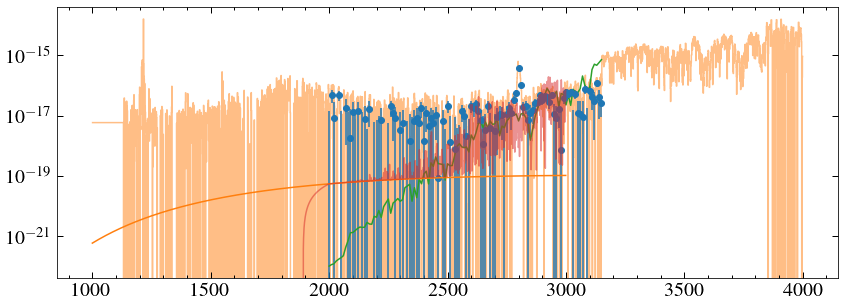

GJ15A
107
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0     4.225305768788832e-22


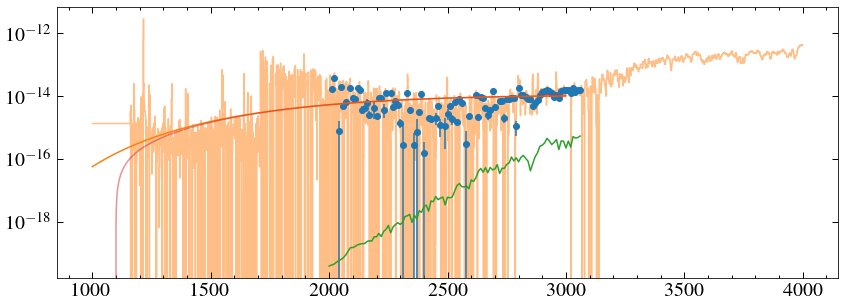

GJ163
115
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    3.6849778957170424e-27


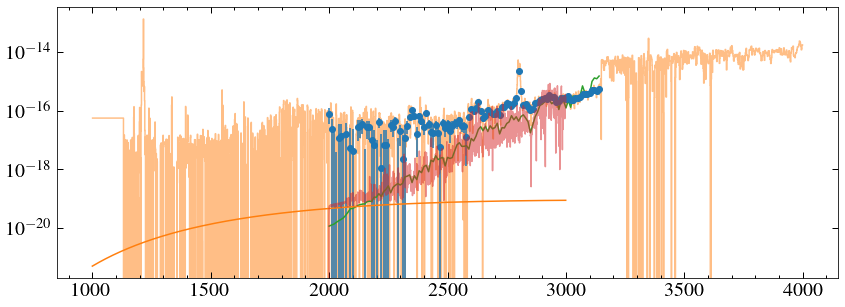

GJ649
116
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    1.9377570334151877e-23


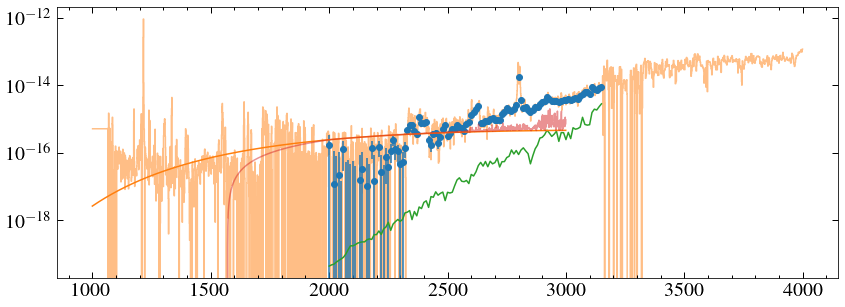

GJ674
116
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    2.5645664357306218e-23


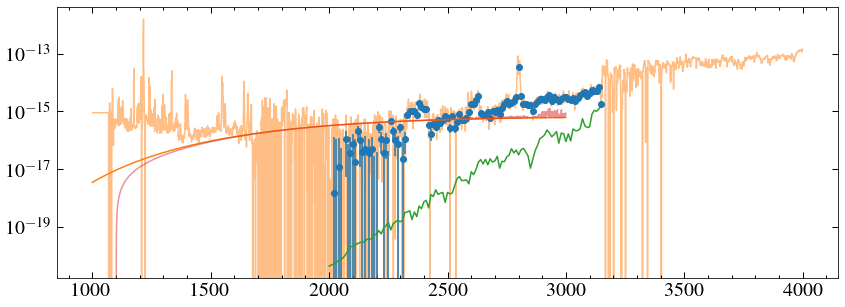

GJ676A
115
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    4.3350939858198265e-23


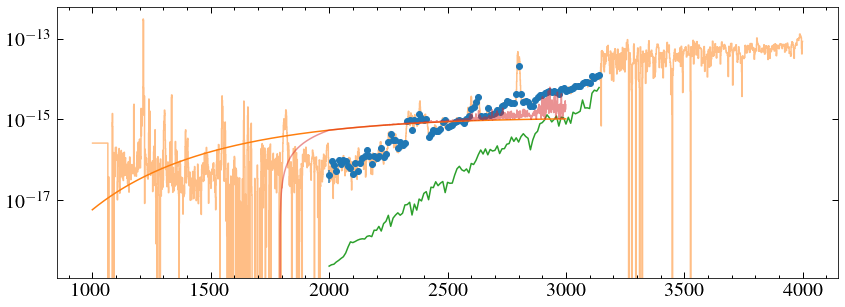

GJ699
116
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0     7.487739762772285e-24


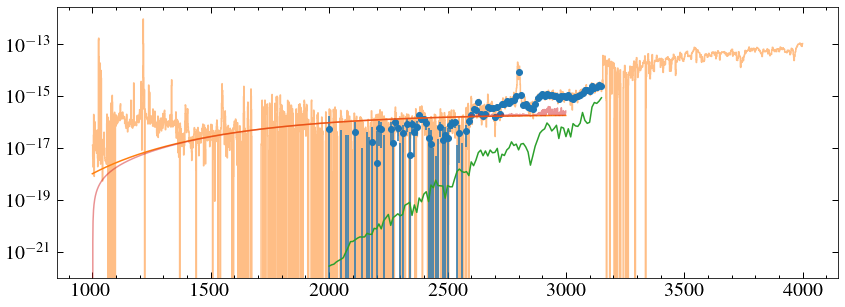

GJ729
107
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    1.0474260759665668e-22


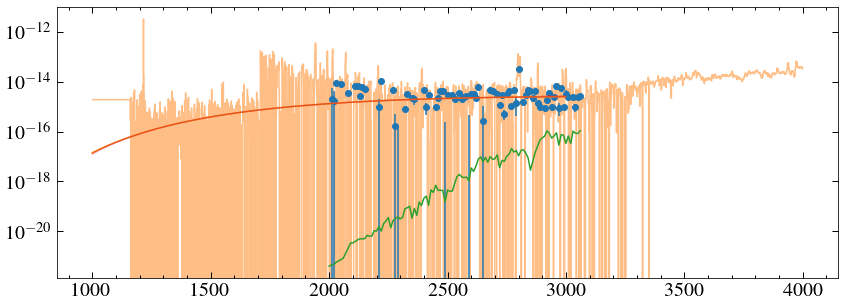

GJ849
116
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    1.2399628625376209e-23


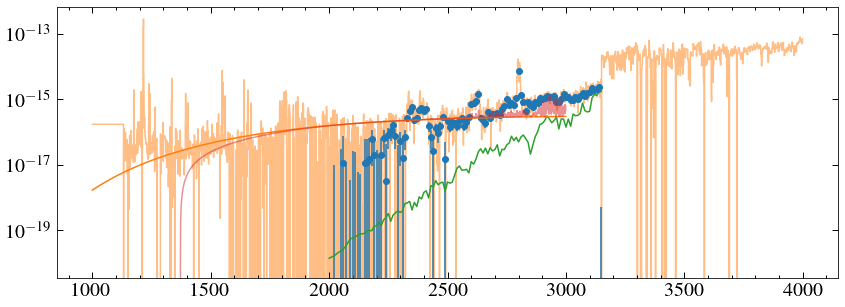

L-980-5
116
Parameter('scale', value=1.0, bounds=(0, None))
Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature           scale          
         K      erg / (Angstrom cm2 s sr)
    ----------- -------------------------
         9000.0    2.0678912608081974e-17


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in true_divide


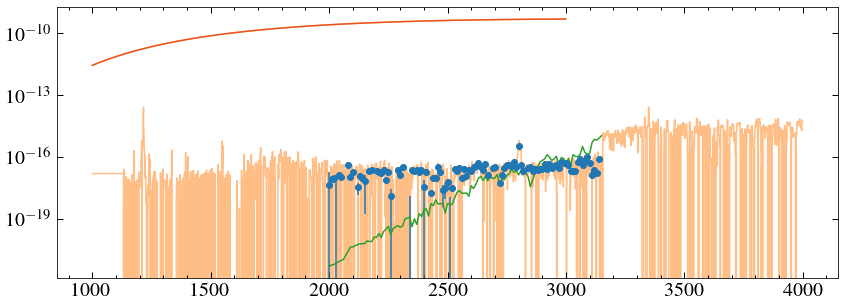

LHS-2686
116
Parameter('scale', value=1.0, bounds=(0, None))


IndexError: boolean index did not match indexed array along dimension 0; dimension is 116 but corresponding boolean dimension is 115

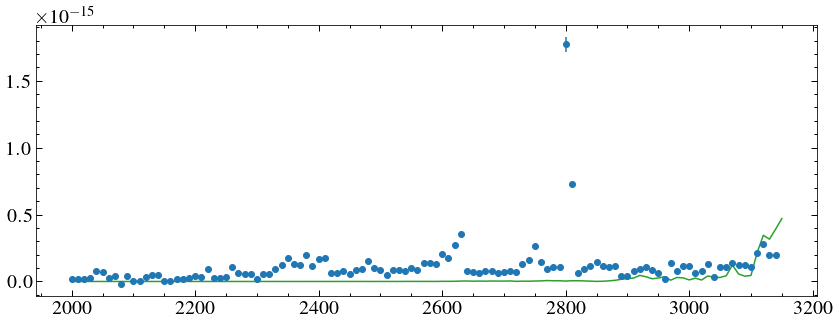

In [9]:
bb = models.BlackBody(temperature=9000*u.K, fixed=dict(temperature=True))#bounds= dict(temperature=[5000*u.k, 13000*u.k])))
wbb = np.arange(1000, 3000, 1)*u.AA
# plt.plot(wbb, bb(wbb))

fitter = fitting.LevMarLSQFitter()

for i, star in enumerate(stars):
    if star != 'TRAPPIST-1':
        print(star)
        nuv = fits.getdata(nuvspecs[i], 1)
        wn, fn, en = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']
        mask = wn > 2000
        wn, fn, en = wn[mask], fn[mask], en[mask]

#         bb = models.BlackBody(temperature=9000*u.K, fixed=dict(temperature=True))
#         scale = np.max(bb(wbb))/np.max(fn)
#         bb.scale=1/scale.value
#         bb_fit = fitter(bb, wn*u.AA, fn, weights = 1/en)

#         plt.step(wn, fn, where='mid')
#         # plt.plot(wbb, bb_fit(wbb), zorder=10)

        phx = fits.getdata(phxspecs[i], 1)
        normfac = fits.getheader(phxspecs[0])['NORMFAC']

        wp, fp = phx['WAVELENGTH'], phx['FLUX']
        mask = (wp > 2000) & (wp < wn[-1])
        wp, fp = wp[mask], fp[mask]*normfac
#         # plt.plot(wp, fp)
#         # plt.yscale('log')

        sed = fits.getdata(seds[i])
        mask = (sed['WAVELENGTH'] > 1000) & (sed['WAVELENGTH'] < 4000)
#         # plt.step(sed['WAVELENGTH'][mask], sed['FLUX'][mask], where='mid', zorder=-10, alpha=0.5)

#         print(bb_fit)

        # plt.show()


        binw = np.arange(2000, wn[-1], 10)
        # wn, fn, en = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']
        # wn[0]
        wnb, fnb, enb = resample.bintogrid(wn, fn, newx=binw, unc = en) 
        # print(len(wnb))
        
        plt.errorbar(wnb, fnb, enb, ls='none', marker='o')
        wpb, fpb = resample.bintogrid(wp, fp, newx=binw)
        print(len(wpb))
        plt.plot(wpb, fpb, c='C2')
        bb = models.BlackBody(temperature=9000*u.K, fixed=dict(temperature=True))# bounds = dict(temperature=[7000*u.k, 11000*u.k])) )
        # bb = models.BlackBody(temperature=9000*u.K, bounds = dict(temperature=[5000*u.K, 15000*u.K])) 
        print(bb.scale)
        mg_mask =  (wnb < 2300) | (wnb > 2450) &  (wnb < 2780) | (wnb > 2820)
        # scale = (np.max(fnb[mg_mask]-fpb[mg_mask])/np.max(bb(wbb)))*1e-12
        # print(scale)
        # bb.scale=(scale.value)*(u.erg/u.s/u.cm**2/u.AA/u.sr)#/(4*np.pi*u.sr)
        # bb.scale = (fnb[-1])*(u.erg/u.s/u.cm**2/u.AA/u.sr)#/(4*np.pi*u.sr)
        bb.scale = np.median(fnb)*(u.erg/u.s/u.cm**2/u.AA/u.sr)#/(4*np.pi*u.sr)
        # print(bb.scale)
        fitf = fnb[mg_mask]-fpb[mg_mask]
        fite = fitf*(enb[mg_mask]/fnb[mg_mask])
        fitw = wnb[mg_mask]
        # emask = fitf/fite > 1
        # fitw, fitf, fite = fitw[emask], fitf[emask], fite[emask]
        # bb1 = fitting.FittingWithOutlierRemoval(bb, sigma_clip, niter=3, sigma=3.0)
        bb_fit = fitter(bb, (fitw)*u.AA, fitf*(u.erg/u.s/u.cm**2/u.AA), weights = 1/(fite*(u.erg/u.s/u.cm**2/u.AA)), maxiter=100000)
        # bb_fit = fitter(bb, (fitw)*u.AA, fitf, weights = 1/fitf, maxiter=100000)
        

        print(bb_fit)

        # plt.step(wn, fn, where='mid')
        plt.plot(wbb, bb_fit(wbb), zorder=10, c='C1')
        pfbb = interpolate.interp1d(wp, fp, fill_value='extrapolate')(wbb)
        # print(bb_fit(wbb))
        plt.plot(wbb, bb_fit(wbb).value+pfbb, zorder=12, c='C3', alpha=0.5)
        # plt.plot(wbb, bb(wbb).value+pfbb, zorder=12, c='C4', alpha=0.5)

        plt.step(sed['WAVELENGTH'][mask], sed['FLUX'][mask], where='mid', zorder=-10, alpha=0.5)

        plt.yscale('log')
        plt.show()

In [ ]:
# wtest = np.linspace(1000, 5000, 100)*u.AA
# bbtest= models.BlackBody(temperature=9000*u.K, scale=1*(u.erg/u.s/u.cm**2/u.AA/u.sr))
# plt.plot(wtest, bbtest(wtest))
# plt.plot(wtest, bbtest(wtest).to((u.erg/u.s/u.cm**2/u.AA)))

In [ ]:
plt.plot(np.arange(1000, 10000, 100)*u.AA, bb_fit(np.arange(1000, 10000, 100)*u.AA))
bb_fit